# Salary prediction

This project uses multiple machine learning models for classification and compares their scores. Throughout the project I inspected each feature and handled it in the way I assumed was appropriate. In that way, the preprocessing of the data consists of data cleaning and analysis, including some visualizations.


The dataset can be found on [Kaggle](https://www.kaggle.com/datasets/ayessa/salary-prediction-classification).

In [33]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics
import seaborn as sns

#importing the data locally
sal = pd.read_csv('../salary/salary.csv')

sal.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Let's inspect each column to find if there is some error or anomaly in the data.

The classification prediction is going to be regarding salary. To be more precise, is the salary of more or less than 50k. So that is the feature we are going to start with.

### Salary

First let's make this boolean variable (0 for <=50, 1 for >50).

In [2]:
sal['salary'] = sal['salary'].replace(to_replace = ' <=50K', value = 0)
sal['salary'] = sal['salary'].replace(to_replace = ' >50K', value = 1)

#checking if all values are 0 and 1
print(sal['salary'].unique())

[0 1]


We are continuing with the general view of the data. The first step in the cleaning process is to see if all the columns have an appropriate data type and remove the null values.

In [3]:
sal.info()
sal.isnull().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
salary            0.0
dtype: float64

At the first glance, it seems like the data is quite clean. Let's continue.

### workclass and occupation

In [4]:
sal['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

We have a ' ?' entry. It might be an error or a common input. Let's see what is happening in these entries.

In [5]:
print(sal.loc[sal['workclass'] == ' ?'])

       age workclass  fnlwgt      education  education-num  \
27      54         ?  180211   Some-college             10   
61      32         ?  293936        7th-8th              4   
69      25         ?  200681   Some-college             10   
77      67         ?  212759           10th              6   
106     17         ?  304873           10th              6   
...    ...       ...     ...            ...            ...   
32530   35         ?  320084      Bachelors             13   
32531   30         ?   33811      Bachelors             13   
32539   71         ?  287372      Doctorate             16   
32541   41         ?  202822        HS-grad              9   
32542   72         ?  129912        HS-grad              9   

               marital-status occupation    relationship                 race  \
27         Married-civ-spouse          ?         Husband   Asian-Pac-Islander   
61      Married-spouse-absent          ?   Not-in-family                White   
69          

There are 1836 entries like that. Let's treat them as a null values. We can also see that the 'occupation' column has the same values so let's get rid of all ' ?' in the dataset.

In [6]:
for column in sal:
    sal.loc[sal[column] == ' ?', column] = np.nan
    
#checking the state of null values
sal.isnull().mean()

age               0.000000
workclass         0.056386
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.056601
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    0.017905
salary            0.000000
dtype: float64

Now we have a better view of null values. Let's dig deeper into each column with null values and resolve the problem.

I am going to approach it by making columns 'workclass' and 'occupation' boolean variables, where the value is going to be True if there is a value and False if it is NaN (or in our case ' ?'). This will help me to try and see if there is an obvious relationship between having the value and salary smaller or greater than 50k.

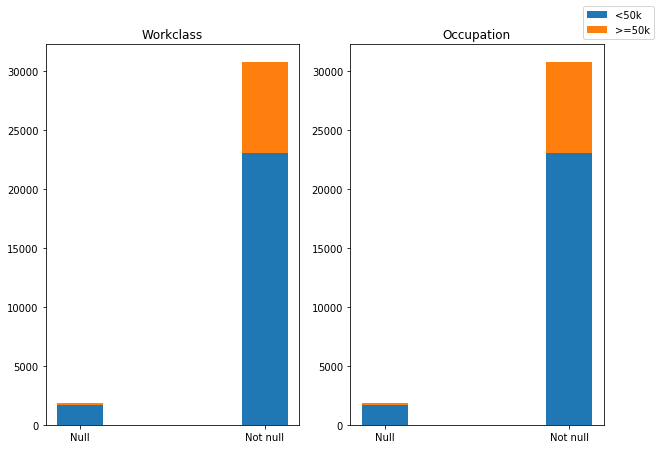

In [7]:
sal['workclass'] = (sal['workclass'].notnull()).astype('int')
sal['occupation'] = (sal['occupation'].notnull()).astype('int')


#splitting into two datasets one with salary <50k and one with >=50k
sal_0 = sal[sal['salary'] == 0]
sal_1 = sal[sal['salary'] == 1]

#plotting the null/not null relationship
fig = plt.subplots(figsize =(10, 7))
plt.subplot(1, 2, 1)
plt.bar(sal_0['workclass'].unique(), sal_0['workclass'].value_counts().to_numpy(), width = 0.25, label = '<50k')
plt.bar(sal_1['workclass'].unique(), sal_1['workclass'].value_counts().to_numpy(),  bottom=sal_0['workclass'].value_counts().to_numpy(), width = 0.25, label = '>=50k')
plt.title('Workclass')
plt.xticks([0, 1], ['Null', 'Not null'])


plt.subplot(1, 2, 2)
plt.bar(sal_0['occupation'].unique(), sal_0['occupation'].value_counts().to_numpy(), width = 0.25, label = '<50k')
plt.bar(sal_1['occupation'].unique(), sal_1['occupation'].value_counts().to_numpy(),  bottom=sal_0['occupation'].value_counts().to_numpy(), width = 0.25, label = '>=50k')
plt.title('Occupation')
plt.xticks([0, 1], ['Null', 'Not null'])
plt.legend(['<50k', '>=50k'], loc='lower left', bbox_to_anchor=(0.9, 1))


plt.show()


These plots are not telling us a lot by themselves. However, the similarity between the two is pretty much obvious. It raises suspicion if the columns are correlated. If yes we could delete one while using both of them for training the machine learning model would be redundant.

(9.0, 0.0)

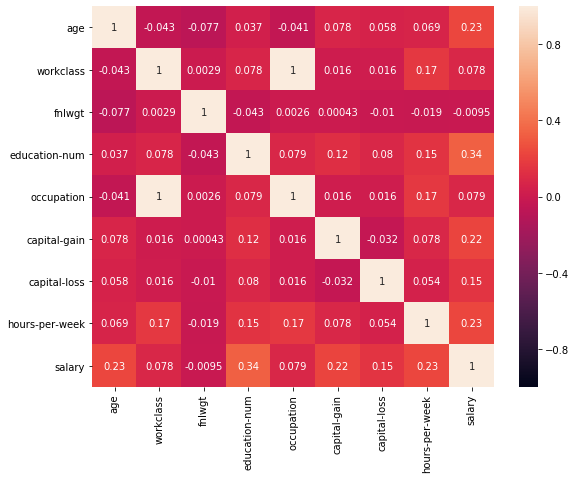

In [8]:
#plotting the correlation matrix
fig = plt.subplots(figsize =(9, 7))
sal_corr = sal.corr()
ax = sns.heatmap(sal_corr, vmax=1, vmin=-1, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Now we can see that 'occupation' and 'workclass' are 1-1, so we can drop one of them.

In [9]:
sal = sal.drop('occupation', axis = 1)

### native-country

Regarding the column 'native-country', there are not as many false values as with the other two columns, so I decided to just get rid of the unwanted rows. Since that is the only column left with NaN values, we can just get rid of all nulls.

In [10]:
sal = sal.dropna()
sal.isnull().mean()

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education-num     0.0
marital-status    0.0
relationship      0.0
race              0.0
sex               0.0
capital-gain      0.0
capital-loss      0.0
hours-per-week    0.0
native-country    0.0
salary            0.0
dtype: float64

### fnlwgt

Fnlwgt or final weight stands for a weight appointed to each row. According to the [report](https://cseweb.ucsd.edu//classes/sp15/cse190-c/reports/sp15/048.pdf), each row should be multiplied by the fnlwgt factor. That would make really big data so I decided to drop that attribute and with that remove the duplicates of the data.

In [11]:
sal = sal.drop('fnlwgt', axis=1)

sal = sal.drop_duplicates()

The next step in data cleaning is to check for outliers. We can do that for numerical variables such as 'capital-gain', 'capital-loss', 'hours-per-week', and 'age'.

### capital-gain and capital-loss

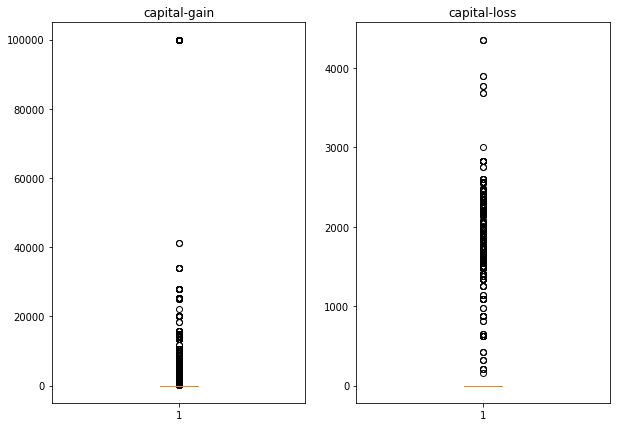

In [12]:
#plotting the boxplot
fig = plt.subplots(figsize =(10, 7))
plt.subplot(1,2,1)
#sns.boxplot(data=sal, x='salary', y='capital-gain')
plt.boxplot(sal['capital-gain'])
plt.title('capital-gain')

plt.subplot(1,2,2)
#sns.boxplot(data=sal, x='salary', y='capital-loss')
plt.boxplot(sal['capital-loss'])
plt.title('capital-loss')
plt.show()

These are very interesting features to deal with regarding the outliers. As we can see the ranges are quite big, and it seems like there are a lot of outliers. I would assume that these outliers are realistic, while there might be people with extremely high or low gain/loss.
So I decided for ML predictions to use two datasets: one where I leave outliers of these two features and one where I remove them. It will be interesting to compare the results of accuracy so we might get a better picture of how these outliers influence the prediction.

In [13]:
#computing the outliers for 'capital-gain'
q1=sal['capital-gain'].quantile(0.25)
q3=sal['capital-gain'].quantile(0.75)
IQR=q3-q1
outliers = sal[((sal['capital-gain']<(q1-1.5*IQR)) | (sal['capital-gain']>(q3+1.5*IQR)))]

sal_out = sal

#removing the outliers in the original sal dataframe
sal = pd.concat([sal,outliers]).drop_duplicates(keep=False)

In [14]:
#computing the outliers for 'capital-loss'
q1=sal['capital-loss'].quantile(0.25)
q3=sal['capital-loss'].quantile(0.75)
IQR=q3-q1
outliers = sal[((sal['capital-loss']<(q1-1.5*IQR)) | (sal['capital-loss']>(q3+1.5*IQR)))]

#removing the outliers in the original sal dataframe
sal = pd.concat([sal,outliers]).drop_duplicates(keep=False)

### hours-per-week

[13. 40. 16. 45. 80. 30. 50. 35. 60. 20. 52. 44. 15. 25. 43. 38. 55. 48.
 58. 32. 70.  2. 22. 56. 41. 36. 24. 46. 42. 12. 65.  1. 28. 10. 34. 75.
 33. 54.  8. 64. 19. 72.  5.  6.  9. 37. 21. 26. 14.  4. 18.  7. 99. 47.
 53. 39. 62. 59. 57. 78. 90. 66. 11. 49. 84.  3. 17. 68. 27. 98. 85. 31.
 51. 63. 23. 87. 88. 73. 89. 97. 94. 29. 77. 96. 82. 86. 91. 81. 76. 92.
 61. 74. 95. 67.]


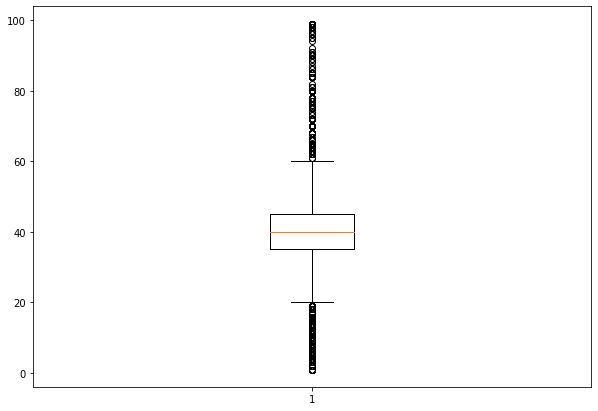

In [15]:
print(sal['hours-per-week'].unique())

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sal['hours-per-week'])
plt.show()

All the values seem okay. 
These outliers I will remove.

{'whiskers': [<matplotlib.lines.Line2D at 0x195b4ebae88>,
 'caps': [<matplotlib.lines.Line2D at 0x195b4ebd9c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x195b4eba688>],
 'medians': [<matplotlib.lines.Line2D at 0x195b4ebdb48>],
 'fliers': [<matplotlib.lines.Line2D at 0x195b4ec4a08>],
 'means': []}

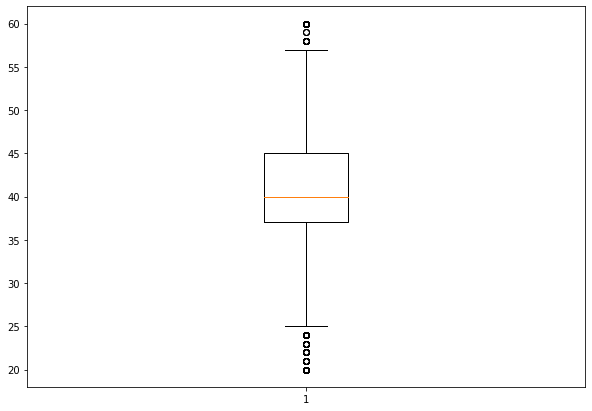

In [16]:
#computing the outliers for 'capital-gain'
q1=sal['hours-per-week'].quantile(0.25)
q3=sal['hours-per-week'].quantile(0.75)
IQR=q3-q1
outliers = sal[((sal['hours-per-week']<(q1-1.5*IQR)) | (sal['hours-per-week']>(q3+1.5*IQR)))]


#removing the outliers in the original sal dataframe
sal = pd.concat([sal,outliers]).drop_duplicates(keep=False)
sal_out = pd.concat([sal,outliers]).drop_duplicates(keep=False)

fig = plt.subplots(figsize =(10, 7))
plt.boxplot(sal['hours-per-week'])



### Age

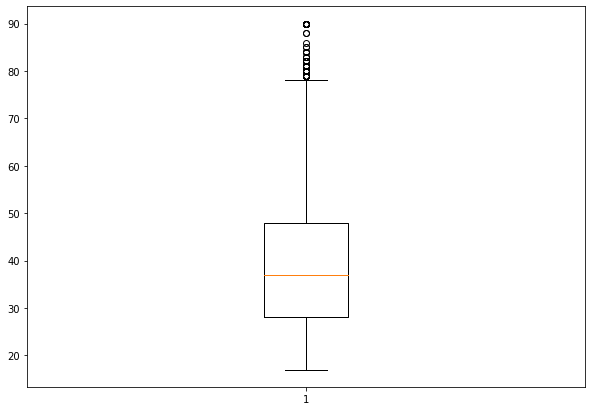

In [17]:
sal['age'].unique()

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sal['age'])
plt.show()

As with the 'hours-per-week', I will remove the outliers.

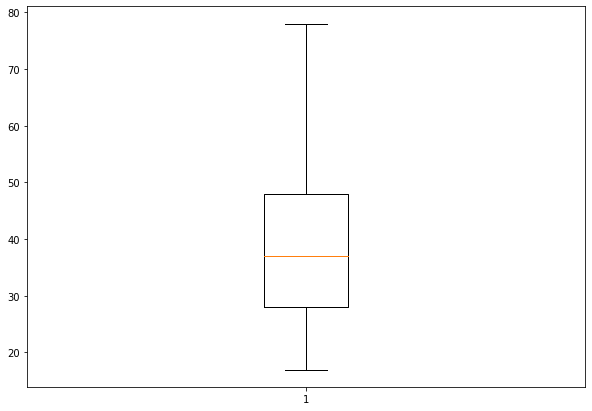

In [18]:
q1=sal['age'].quantile(0.25)
q3=sal['age'].quantile(0.75)
IQR=q3-q1

outliers = sal[((sal['age']<(q1-1.5*IQR)) | (sal['age']>(q3+1.5*IQR)))]

#removing the outliers in the original sal dataframe
sal = pd.concat([sal,outliers]).drop_duplicates(keep=False)
sal_out = pd.concat([sal,outliers]).drop_duplicates(keep=False)

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sal['age'])
plt.show()

Now that we cleaned 'age' from outliers let's see how does the age influence the salary.

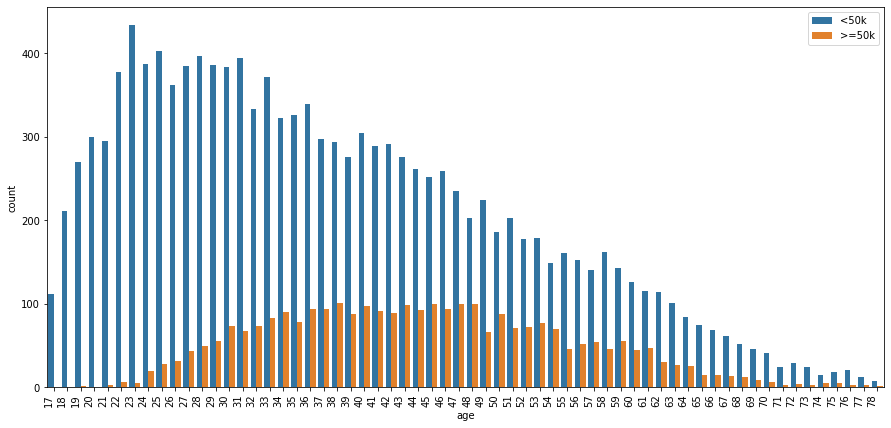

In [19]:
sal['age'] = sal['age'].astype(int)

plt.figure(figsize=(15,7))
ax = sns.countplot(data=sal, x='age', hue='salary')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.legend(['<50k', '>=50k'])
plt.show()

Mostly young and older people have lower (<50k) salaries, while it's people around 40 years old that might get bigger salaries (>=50k) the most.

### education and education-num

These two columns are related, so I am choosing to work with only the numerical one.

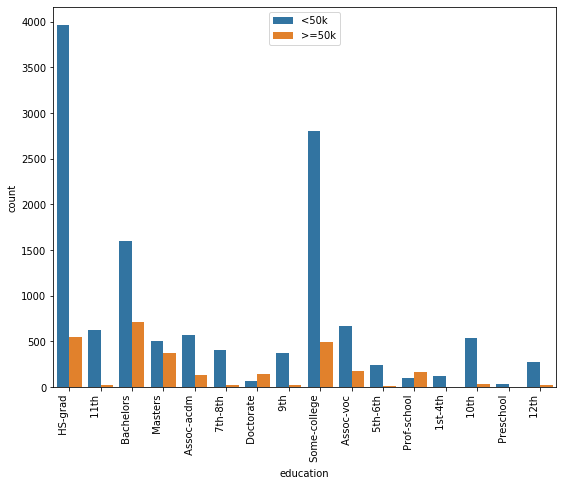

In [20]:
sal = sal.drop('education-num', axis=1)


plt.figure(figsize=(9,7))
ax = sns.countplot(data=sal, x='education', hue='salary')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.legend(['<50k', '>=50k'])
plt.show()

The outcome is as expected. People with higher education like masters, prof-school and doctorate will have a salary greater or equal to 50k while the ones with the lower education will earn less than 50k.

For the last three features I will check if their values make sense.

### marital-status

In [21]:
sal['marital-status'].unique()

array([' Divorced', ' Married-civ-spouse', ' Never-married', ' Separated',
       ' Married-AF-spouse', ' Widowed', ' Married-spouse-absent'],
      dtype=object)

### relationship

In [22]:
sal['relationship'].unique()

array([' Not-in-family', ' Husband', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative'], dtype=object)

### race

In [23]:
sal['race'].unique()

array([' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other'], dtype=object)

## Data prep

To prep the data for training it on a ML model, we need to convert categorical variables into indicator variables.

Also, I chose to split the data into train and test sizes with a ratio of 80/20.


In [24]:
from sklearn.model_selection import train_test_split

features = []
for column in sal:
    if (column == 'salary'):
        continue
    features.append(column)


label = []
score = []

X = pd.get_dummies(sal[features])
y = sal['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 3)

X_out = pd.get_dummies(sal_out[features])
y_out = sal_out['salary']
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size = 0.20, random_state = 3)

## ML models

Let's train the data for each model and predict the values for the test data. In the end, we compare the results of each model in both cases where we left the outliers for the capital loss and gain and the one where we removed them.

### KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.float` is a deprecated alias')

data = []

def knneig(X_train,y_train, X_test, y_test):
    score_knn = 0
    for i in range (1, 11):
        knn = KNeighborsClassifier(n_neighbors = (2*i-1))
        knn.fit(X_train,y_train)
        scr = knn.score(X_test,y_test)
        if score_knn <= scr:
            score_knn = scr
    return score_knn

data.append(['KNN', knneig(X_train,y_train, X_test, y_test), knneig(X_train_out,y_train_out, X_test_out, y_test_out)])


### Decision Tree Classifier

In [36]:
from sklearn.tree import DecisionTreeClassifier


def dectc (X_train, y_train, X_test, y_test):
    score_dtc = 0
    for i in range (1, 20):
        dtc = DecisionTreeClassifier(max_depth = i)
        dtc.fit(X_train,y_train)
        y_pred = dtc.predict(X_test)
        if score_dtc <= metrics.accuracy_score(y_test,y_pred):
            score_dtc = metrics.accuracy_score(y_test,y_pred)
    return score_dtc
        
data.append(['Decision Tree Classifier', dectc(X_train, y_train, X_test, y_test), dectc(X_train_out, y_train_out, X_test_out, y_test_out)])

### Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression

def logreg (X_train, y_train, X_test, y_test):
    lr = LogisticRegression(solver='liblinear', random_state=1)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    score_lr = metrics.accuracy_score(y_test, y_pred)
    return score_lr

data.append(['Logistic regression', logreg(X_train, y_train, X_test, y_test), logreg(X_train_out, y_train_out, X_test_out, y_test_out)])

### Naive Bayes Classifier

In [38]:
from sklearn.naive_bayes import GaussianNB

def naibc (X_train, y_train, X_test, y_test):
    nbc = GaussianNB()
    nbc.fit(X_train, y_train)
    y_pred = nbc.predict(X_test)
    score_nbc = metrics.accuracy_score(y_test, y_pred)
    return(score_nbc)

data.append(['Naive Bayes Classifier', naibc(X_train, y_train, X_test, y_test), naibc(X_train_out, y_train_out, X_test_out, y_test_out)])

### Support Vector Machines

not sure if lineary separable so check linear and rbf

In [39]:
from sklearn.svm import SVC

def supvm (X_train, y_train, X_test, y_test):
    score_svm = 0
    svm = SVC(gamma = 'auto')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    if score_svm < metrics.accuracy_score(y_test, y_pred):
        score_svm = metrics.accuracy_score(y_test, y_pred)
    return (score_svm)

data.append(['Support Vector Machine', supvm(X_train, y_train, X_test, y_test), supvm(X_train_out, y_train_out, X_test_out, y_test_out)])

╒══════════════════════════╤═══════════════╤════════════╕
│ ML model                 │   no outliers │   outliers │
╞══════════════════════════╪═══════════════╪════════════╡
│ KNN                      │      0.814475 │   0.824159 │
├──────────────────────────┼───────────────┼────────────┤
│ Decision Tree Classifier │      0.837863 │   0.846493 │
├──────────────────────────┼───────────────┼────────────┤
│ Logistic regression      │      0.84134  │   0.853413 │
├──────────────────────────┼───────────────┼────────────┤
│ Naive Bayes Classifier   │      0.542351 │   0.555521 │
├──────────────────────────┼───────────────┼────────────┤
│ Support Vector Machine   │      0.818584 │   0.832652 │
╘══════════════════════════╧═══════════════╧════════════╛


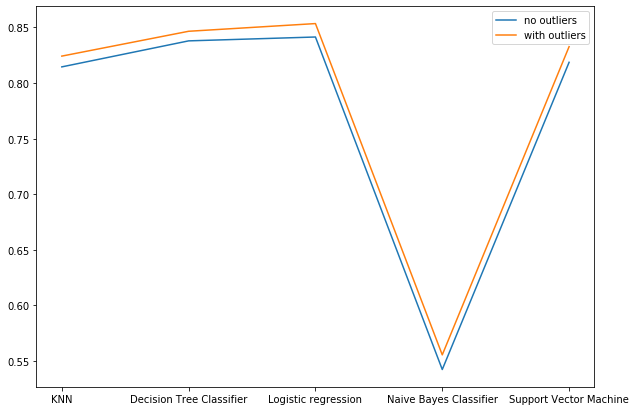

In [40]:
from tabulate import tabulate
col_names = ['ML model', 'no outliers', 'outliers']
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

model =[]
no_out = []
out = []
for i in range (0,5):
    model.append(data[i][0])
    no_out.append(data[i][1])
    out.append(data[i][2])
    

fig = plt.figure(figsize =(10, 7))
plt.plot(model, no_out, label='no outliers')
plt.plot(model, out, label='with outliers')
plt.legend()

## Conclusion

We can see now that not dropping the outliers for capital-loss and capital-gain was a good choice, while it has slightly better prediction results than the one with dropped outliers.

In conclusion, the best performance has logistic regression (>85%), with the training data where we left the outliers of the capital gain and loss.

Thank you for the read. Please do not hesitate to let me know your comments or corrections :)